## Interpreting the model 

In [1]:
# Load appropriate modules
from os import listdir
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras import metrics
import tensorflow as tf
import cv2
tf.compat.v1.disable_eager_execution()
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (8, 8)
%matplotlib inline

In [2]:
# Load in dataframe
train_df = pd.read_csv(r"C:/Users/Jake Wojcik/Documents/Springboard/DS Career Track Course/Capstone_3/Data/train_data.csv",index_col=0)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [3]:
# load in metric functions for our model
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Load model

In [4]:
from keras.models import load_model
#load saved model from folder
loaded_model = load_model(r"C:\Users\Jake Wojcik\Documents\Springboard\DS Career Track Course\Capstone_3\Models\model_final_ov_ep100", custom_objects = {'f1_m':f1_m, 'recall_m':recall_m, 'precision_m':precision_m})
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

### Visualize Activations

To get a better idea of how our CNN is making predictions in each layer, we'll use keract in order to get the activations and gradients of each layer in our network. 

https://github.com/philipperemy/keract

In [5]:
# Sample one damaged and undamaged image 
keract_undamaged_img = plt.imread(train_df.path[9])
keract_damaged_img = plt.imread(train_df.path[9457])

Let's take a look the features the CNN is selecting from each class. First we'll take a look at an undamged image. 

#### Undamaged Image Activations

conv2d (1, 126, 126, 32) 


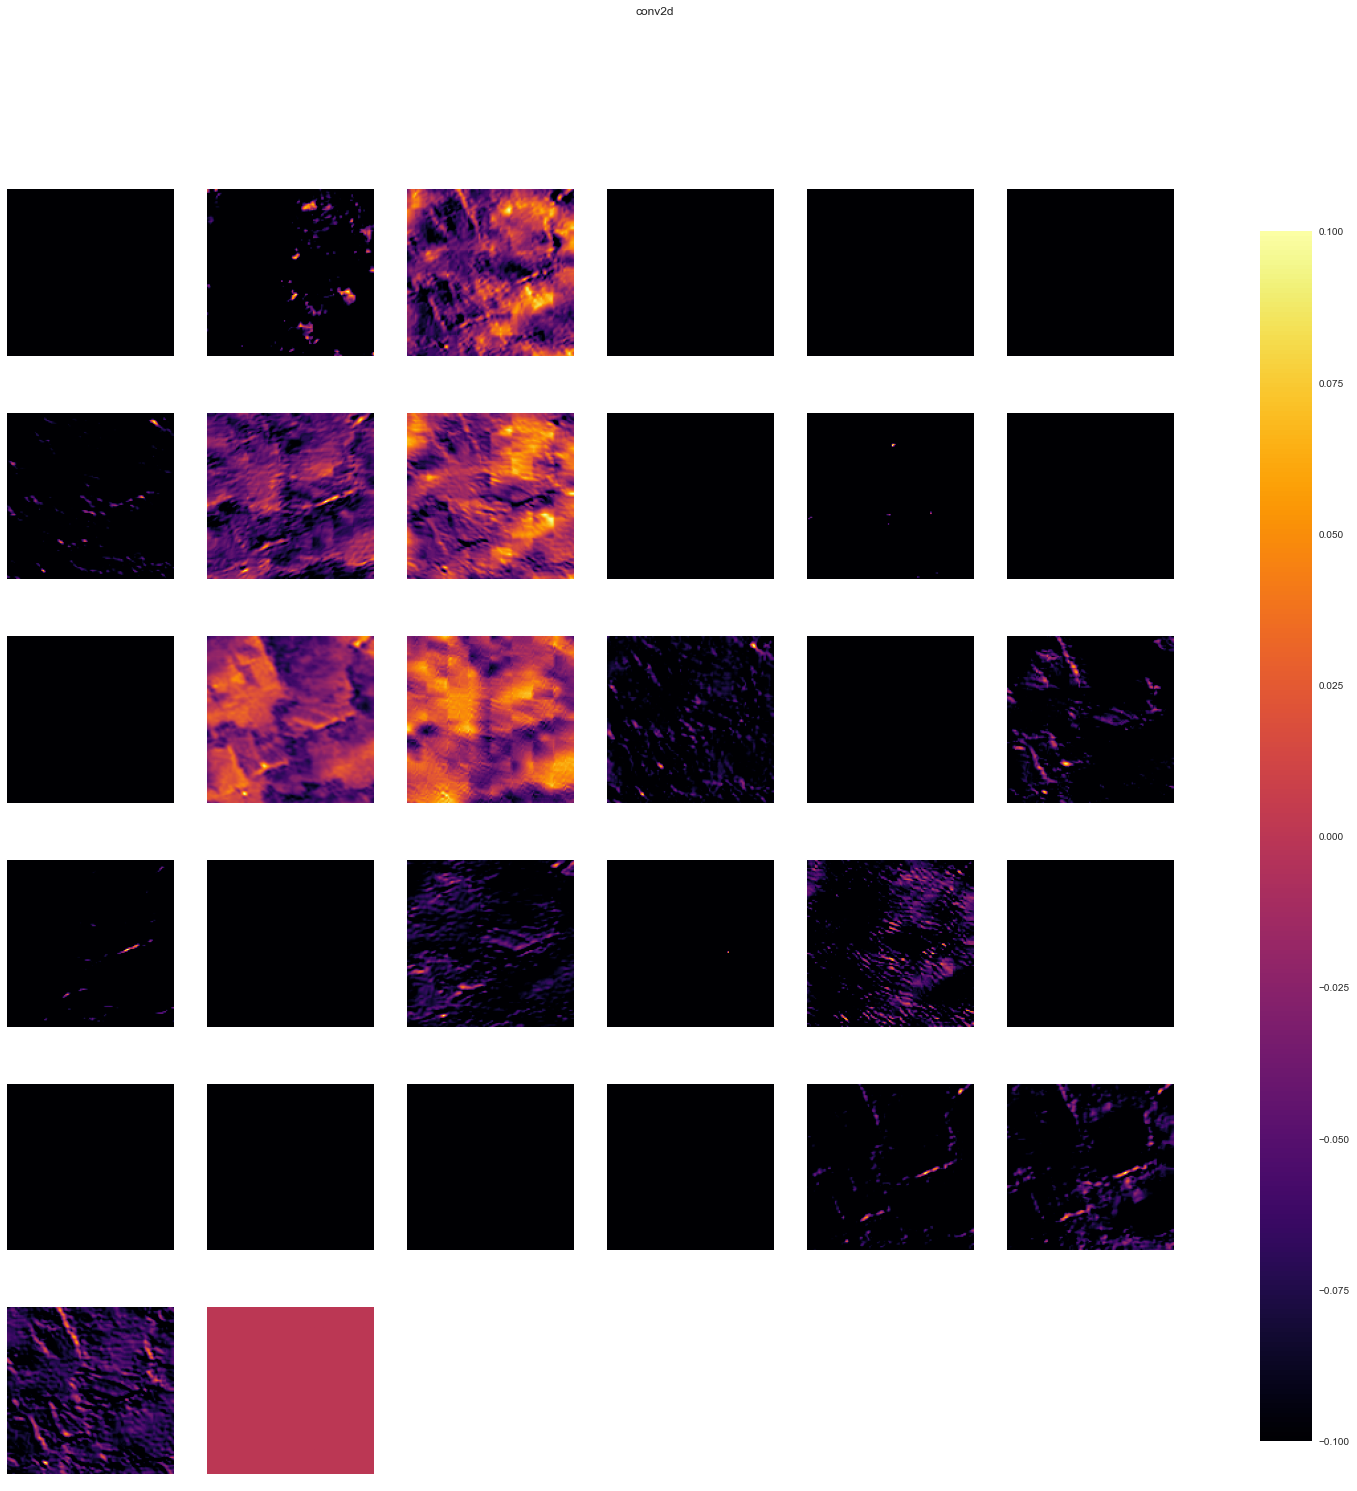

conv2d_1 (1, 61, 61, 64) 


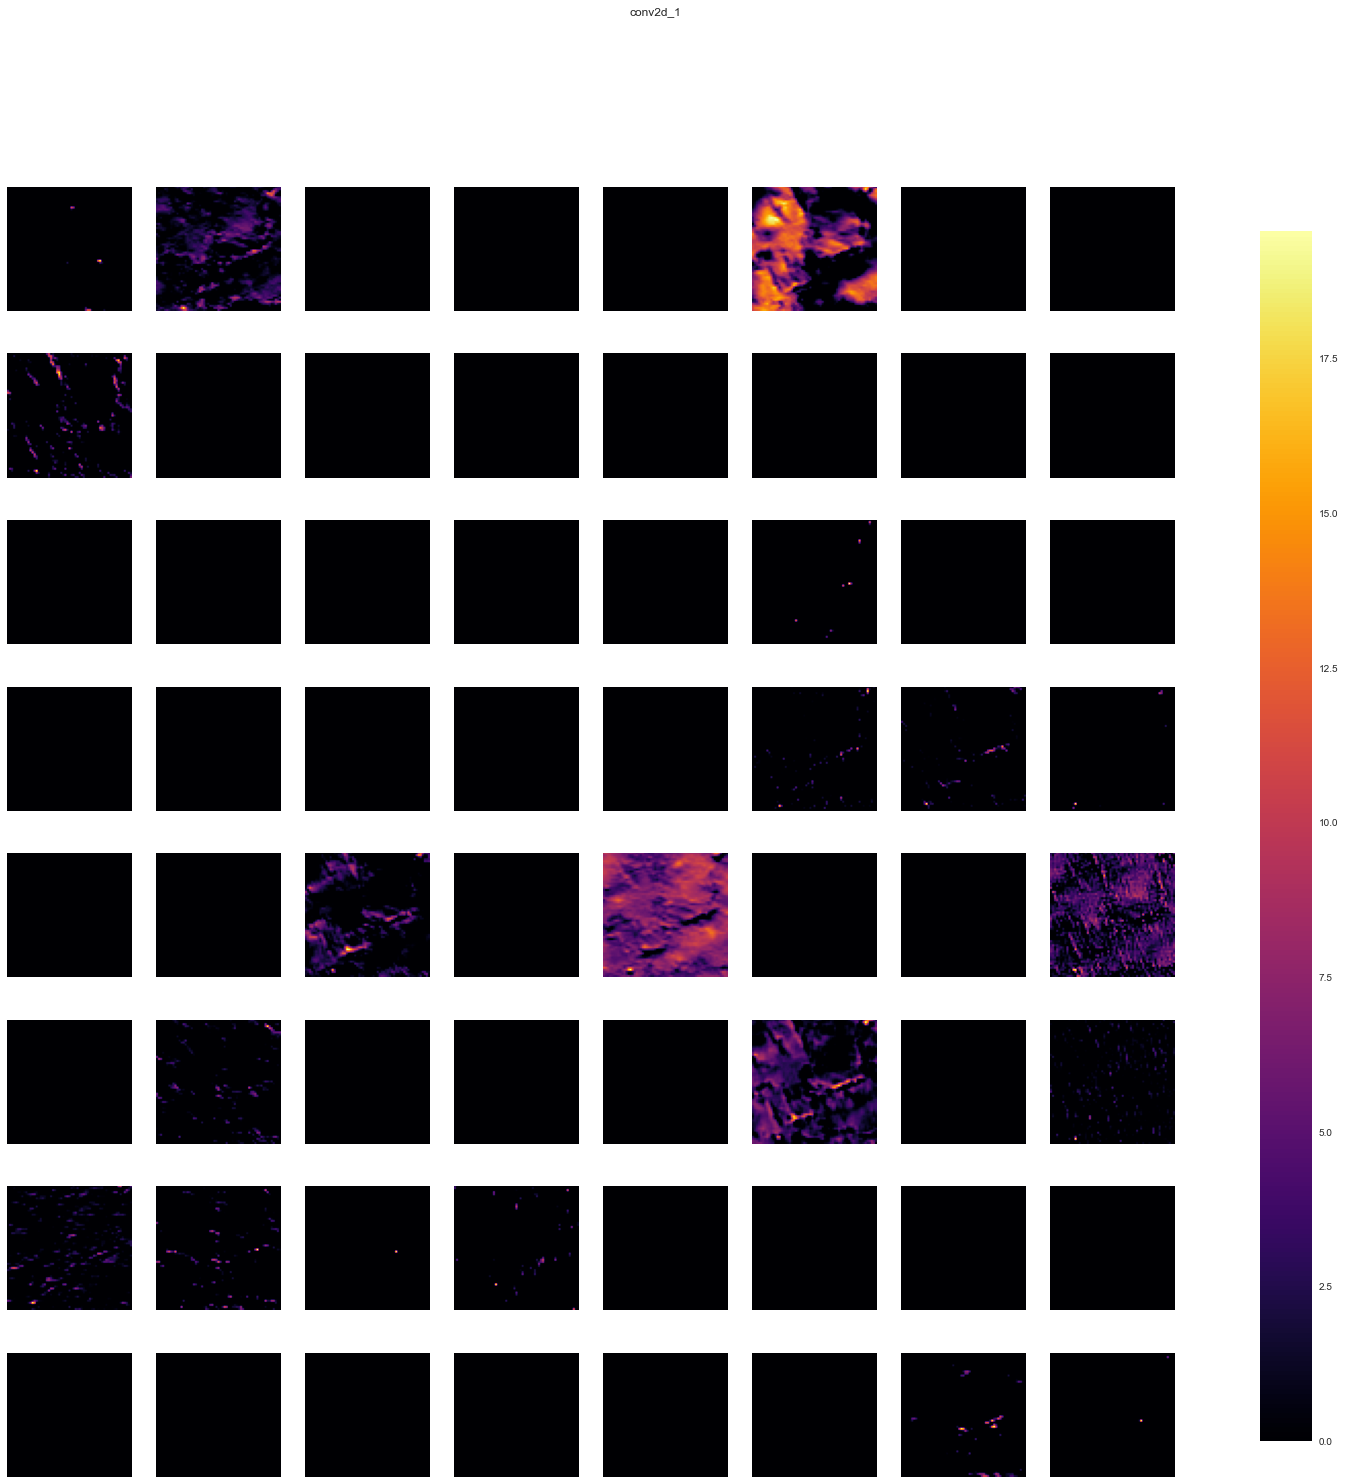

conv2d_2 (1, 28, 28, 128) 


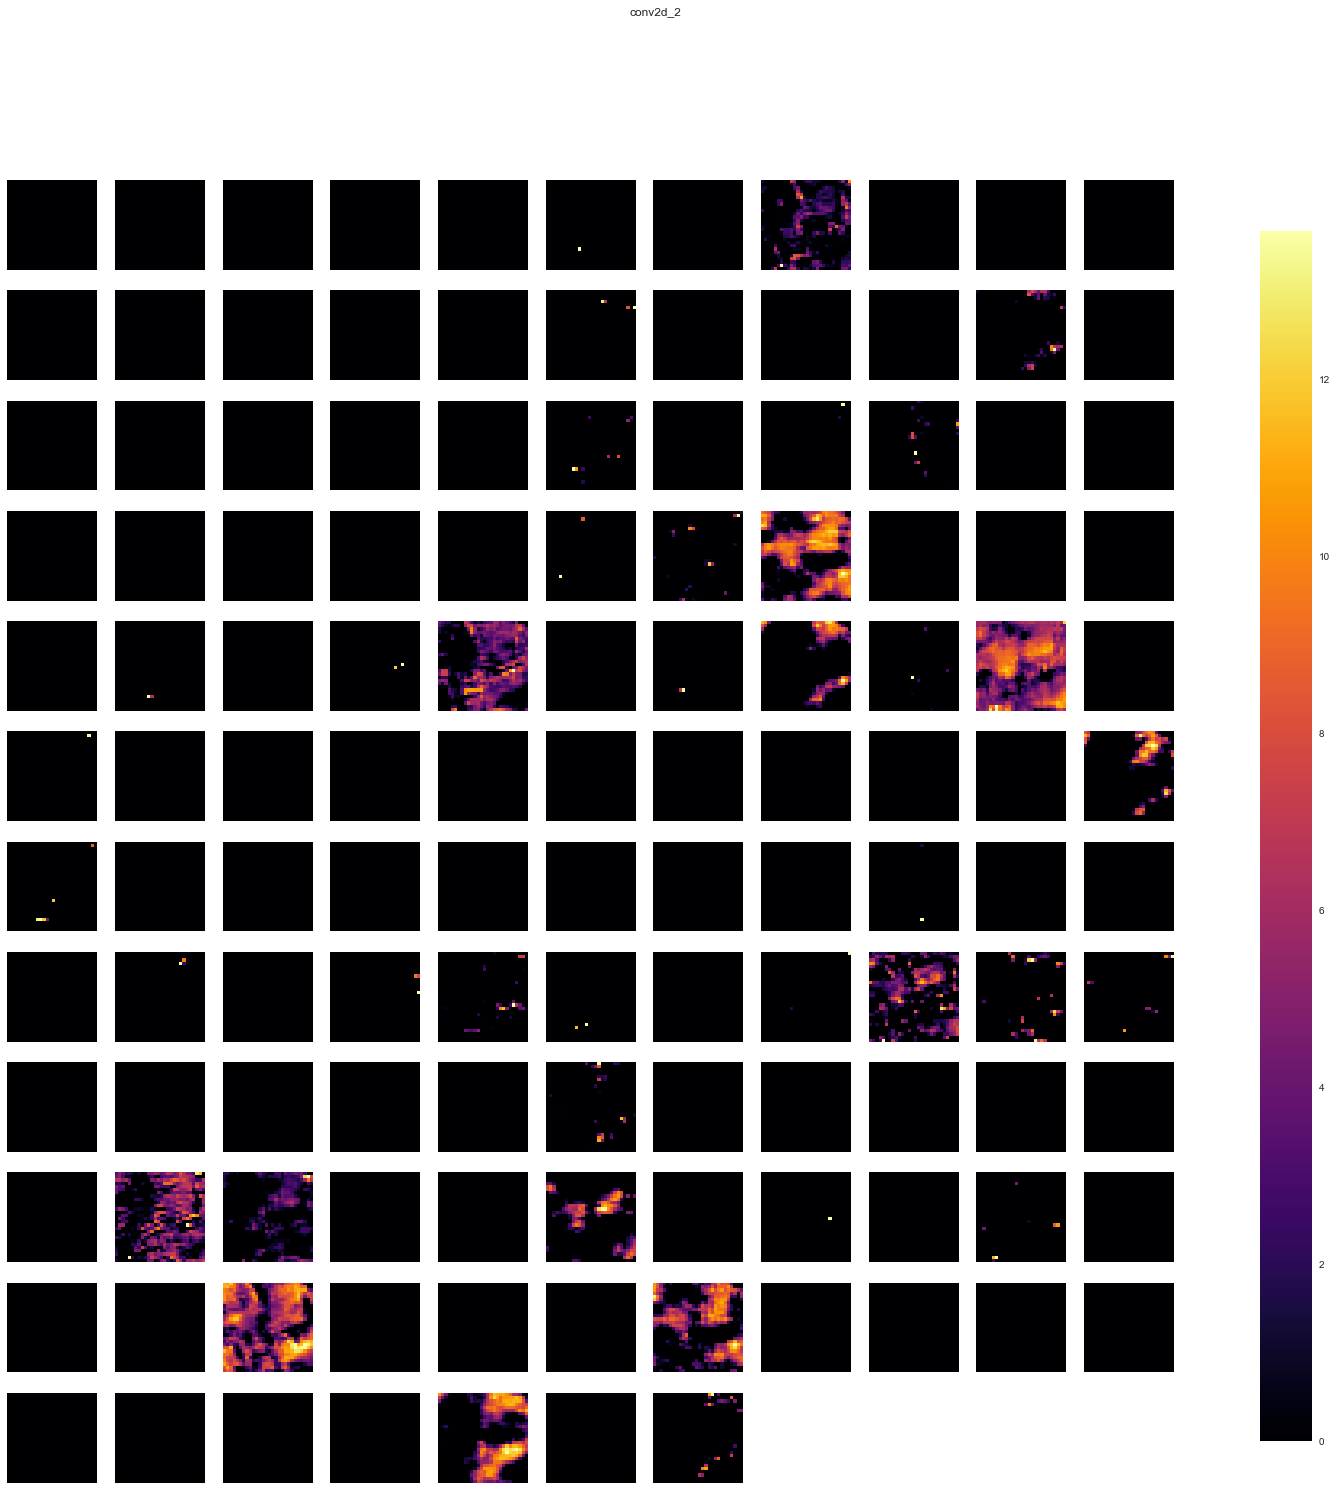

conv2d_3 (1, 12, 12, 128) 


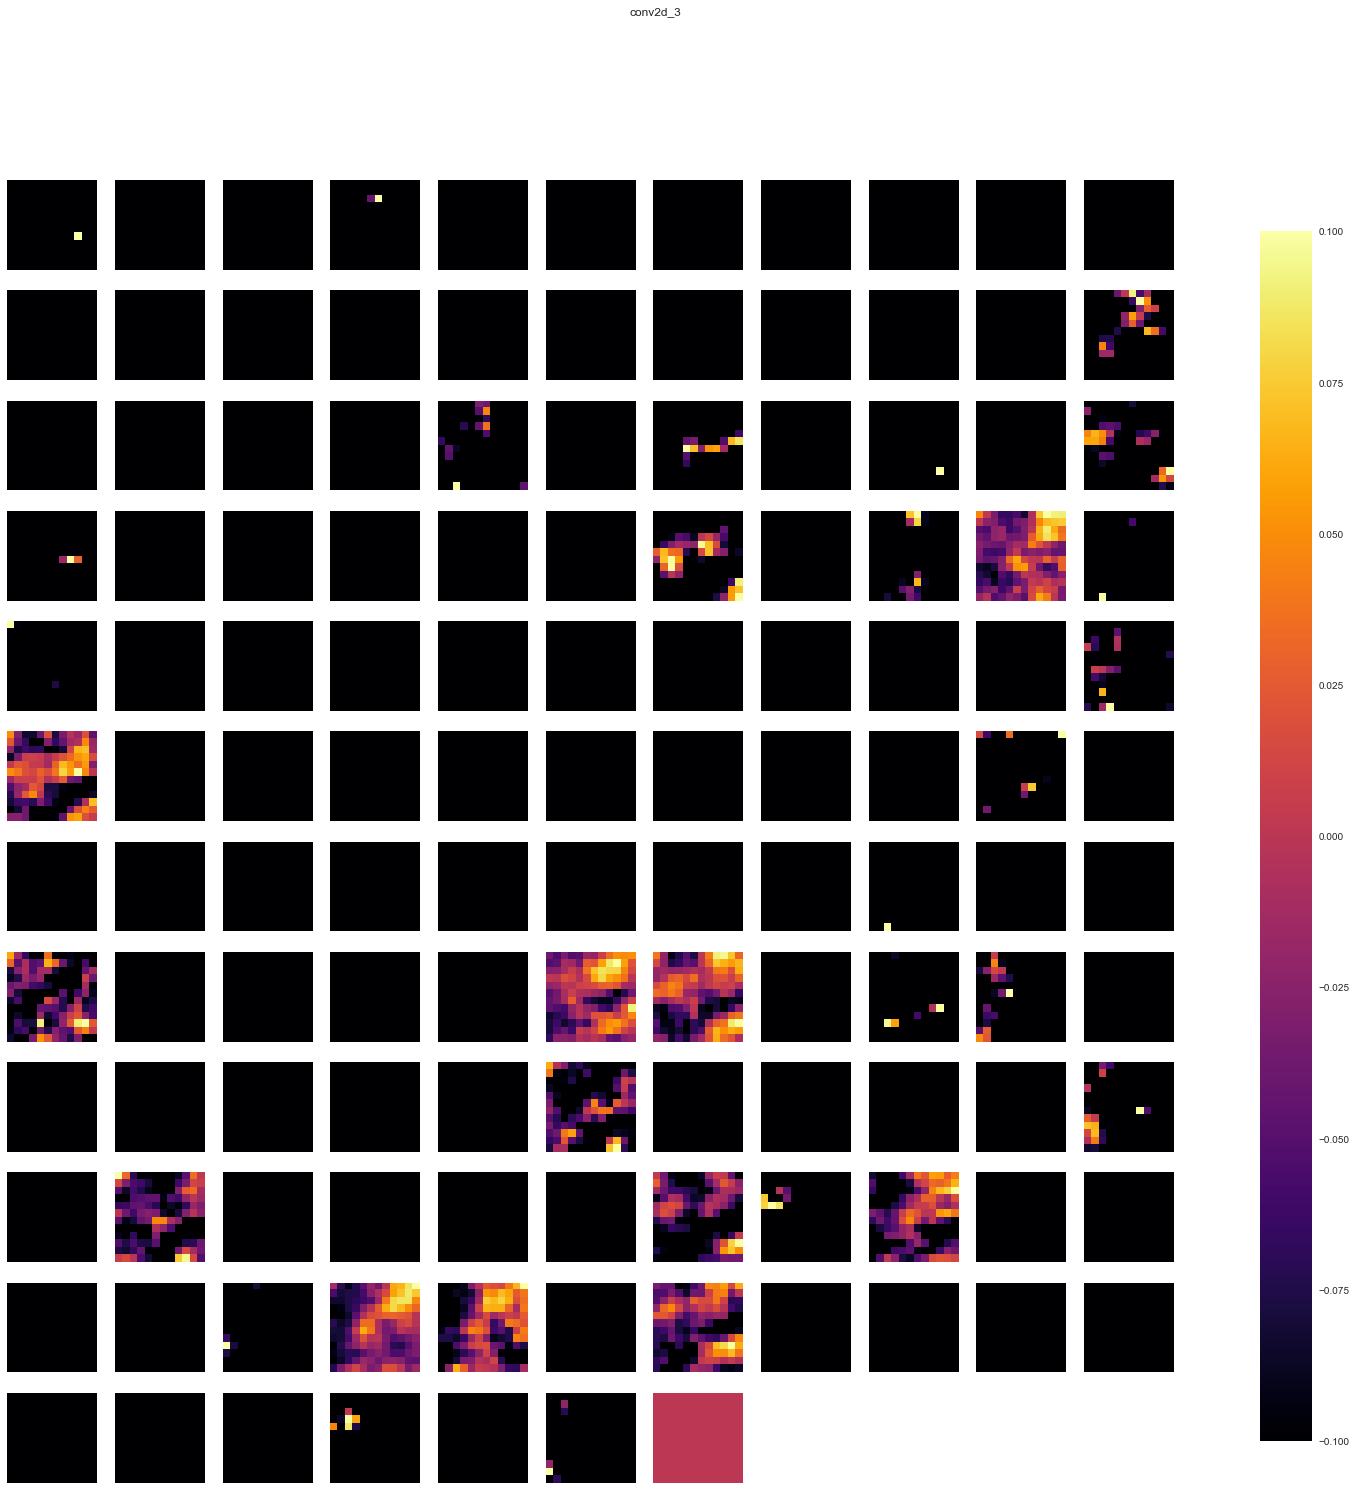

In [6]:
from keract import get_activations, display_activations
from keract import display_heatmaps

activations = get_activations(loaded_model,keract_undamaged_img.reshape(1,128,128,3),
                              layer_names=['conv2d_input_1','conv2d','conv2d_1','conv2d_2','conv2d_3'])
display_activations(activations,cmap= 'inferno',save=False)

#### Damaged Image Activations

conv2d (1, 126, 126, 32) 


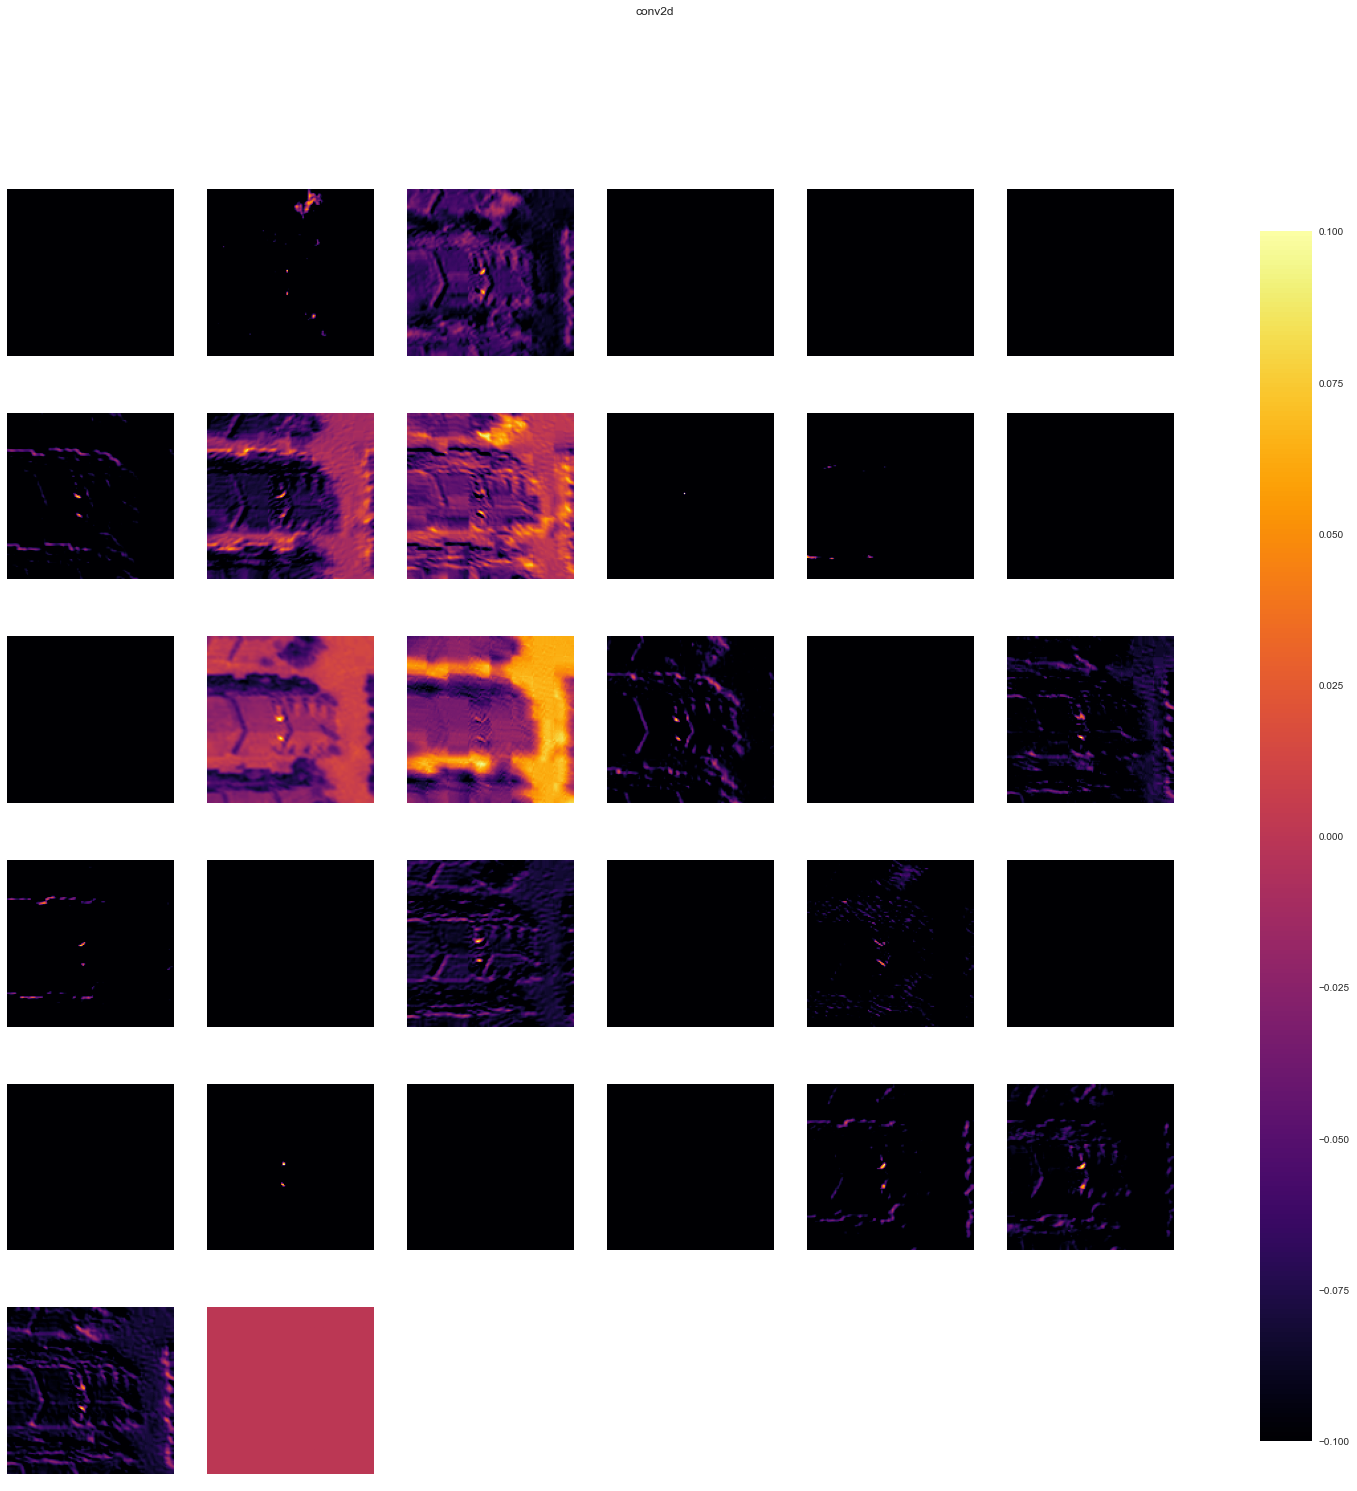

conv2d_1 (1, 61, 61, 64) 


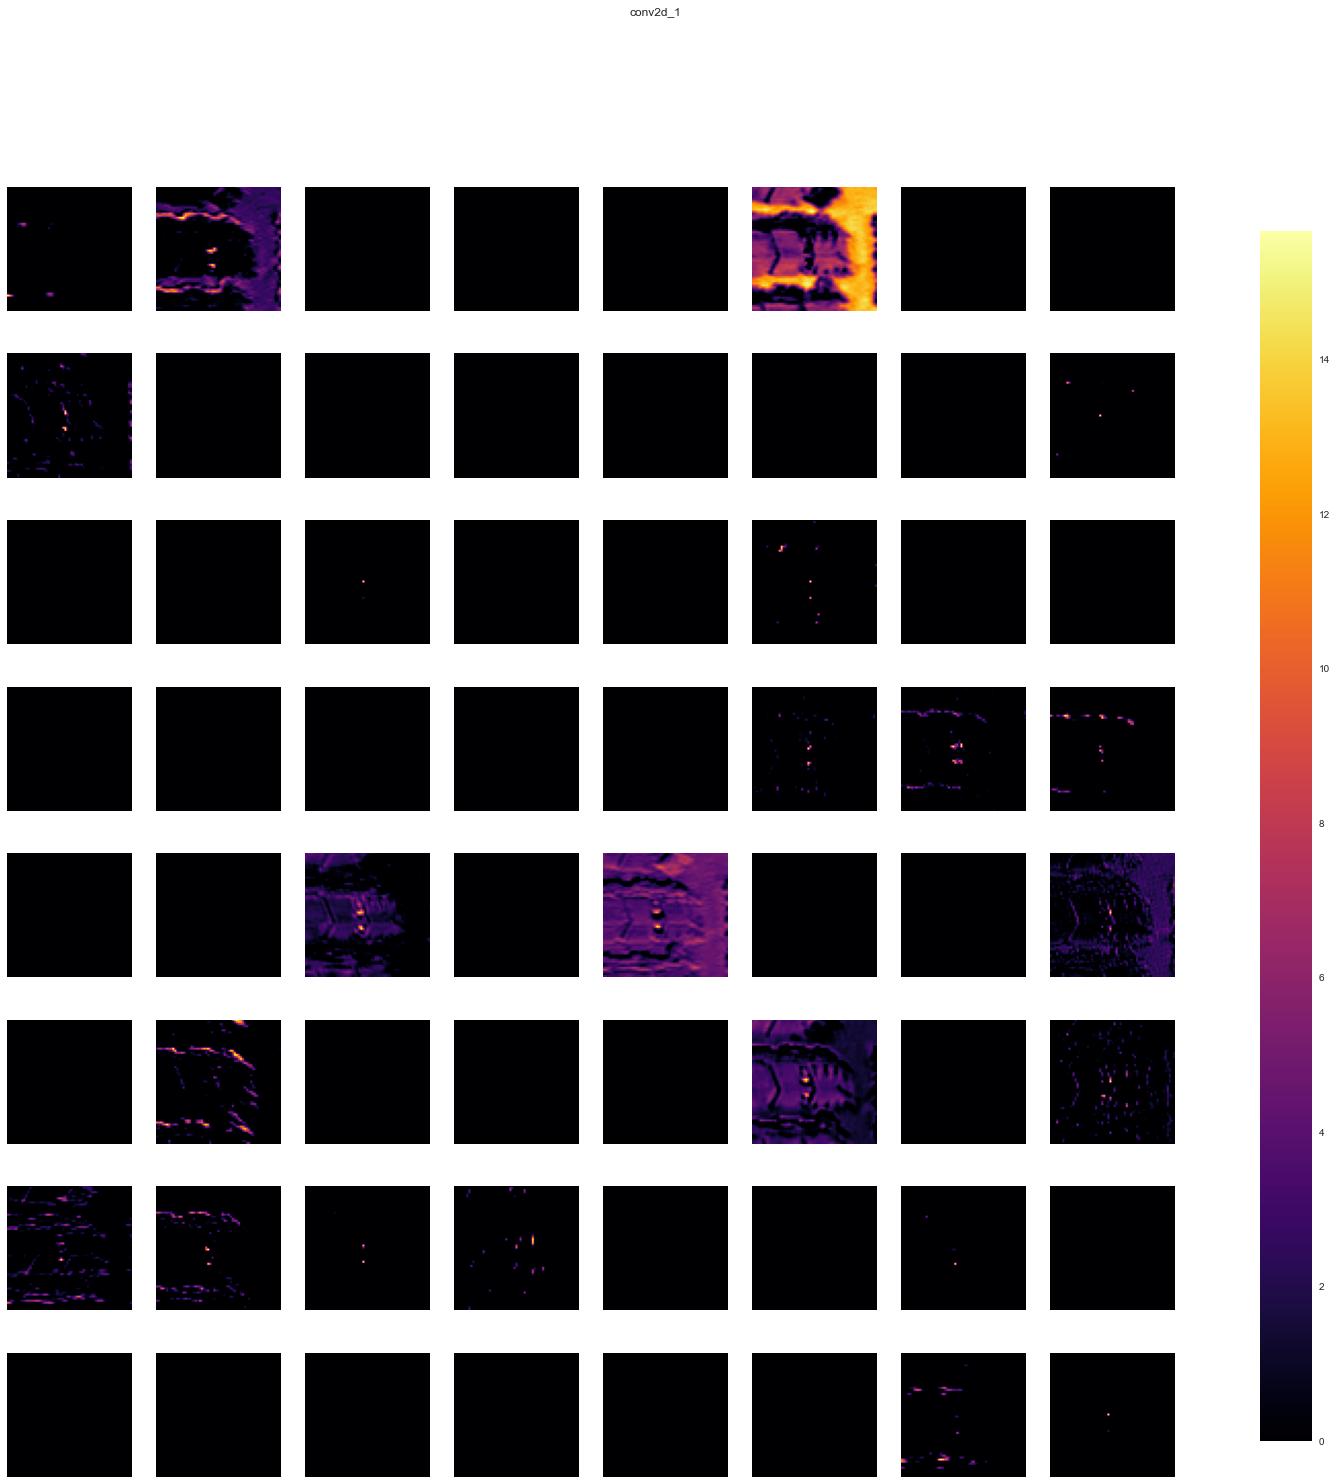

conv2d_2 (1, 28, 28, 128) 


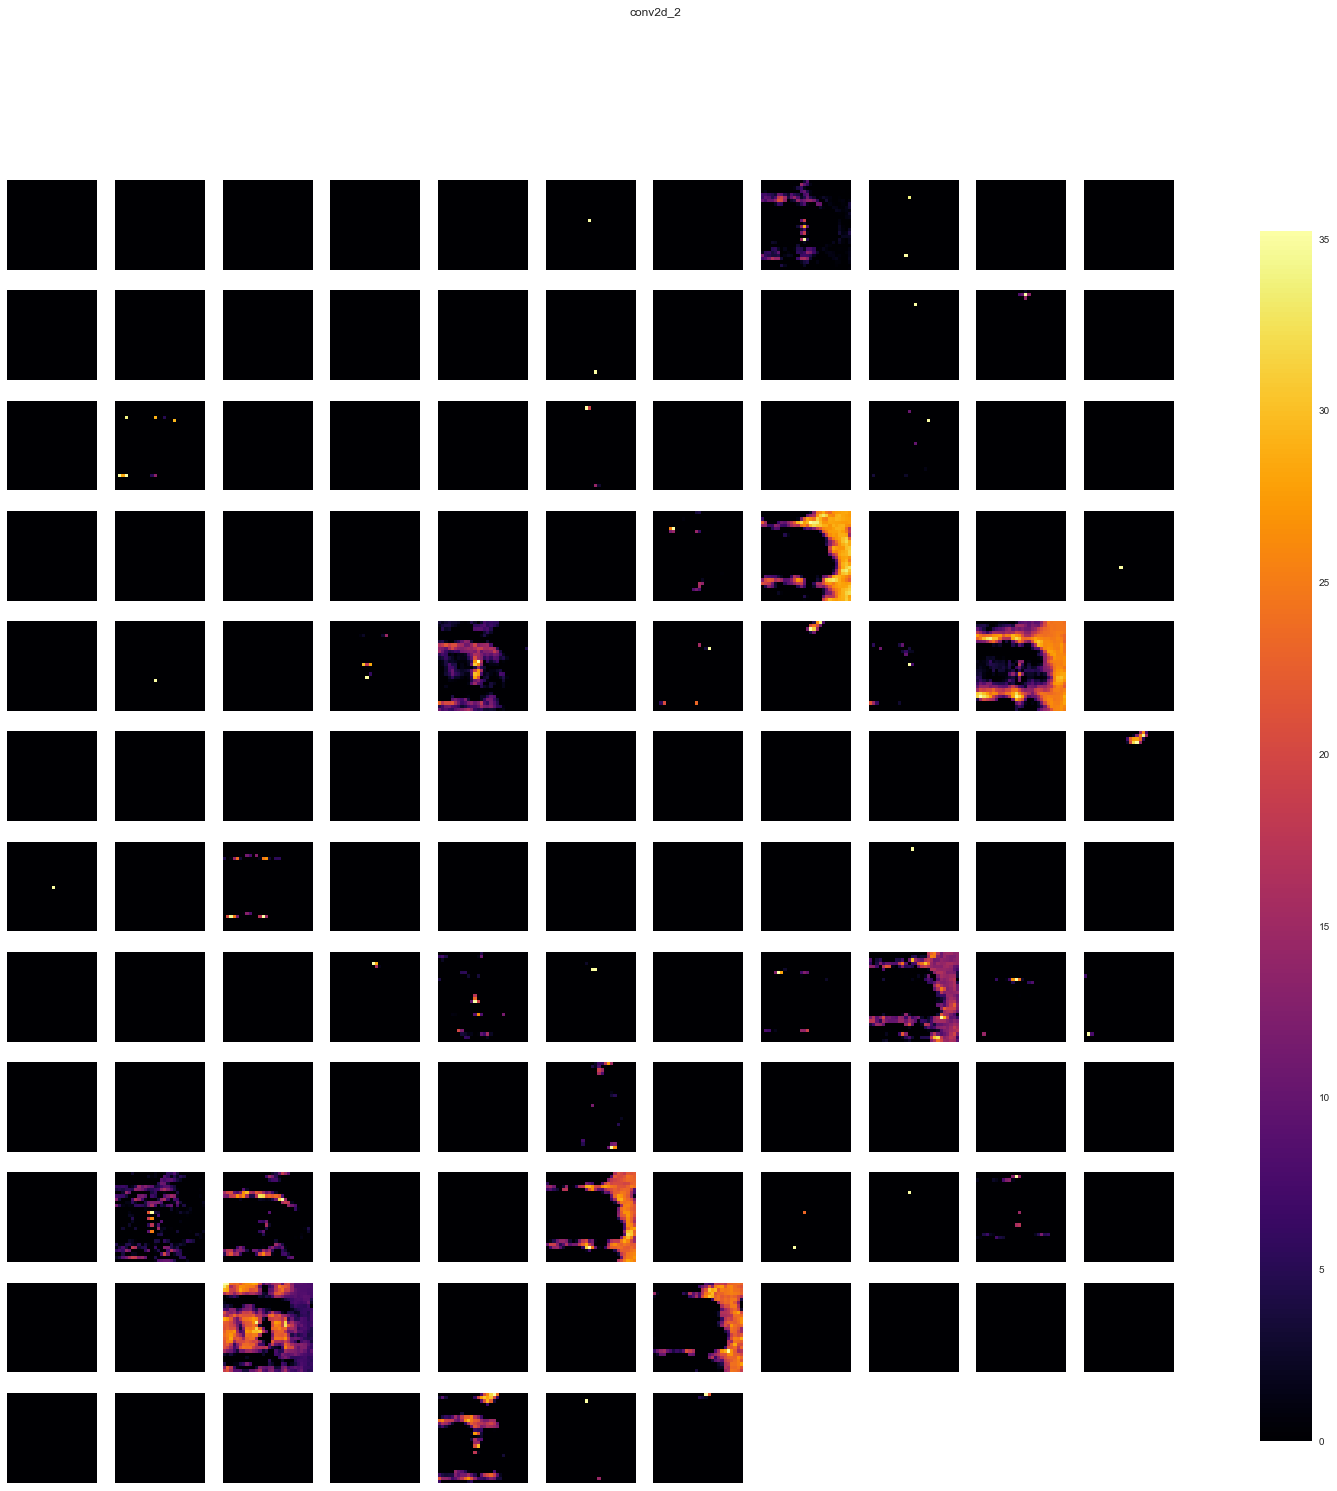

conv2d_3 (1, 12, 12, 128) 


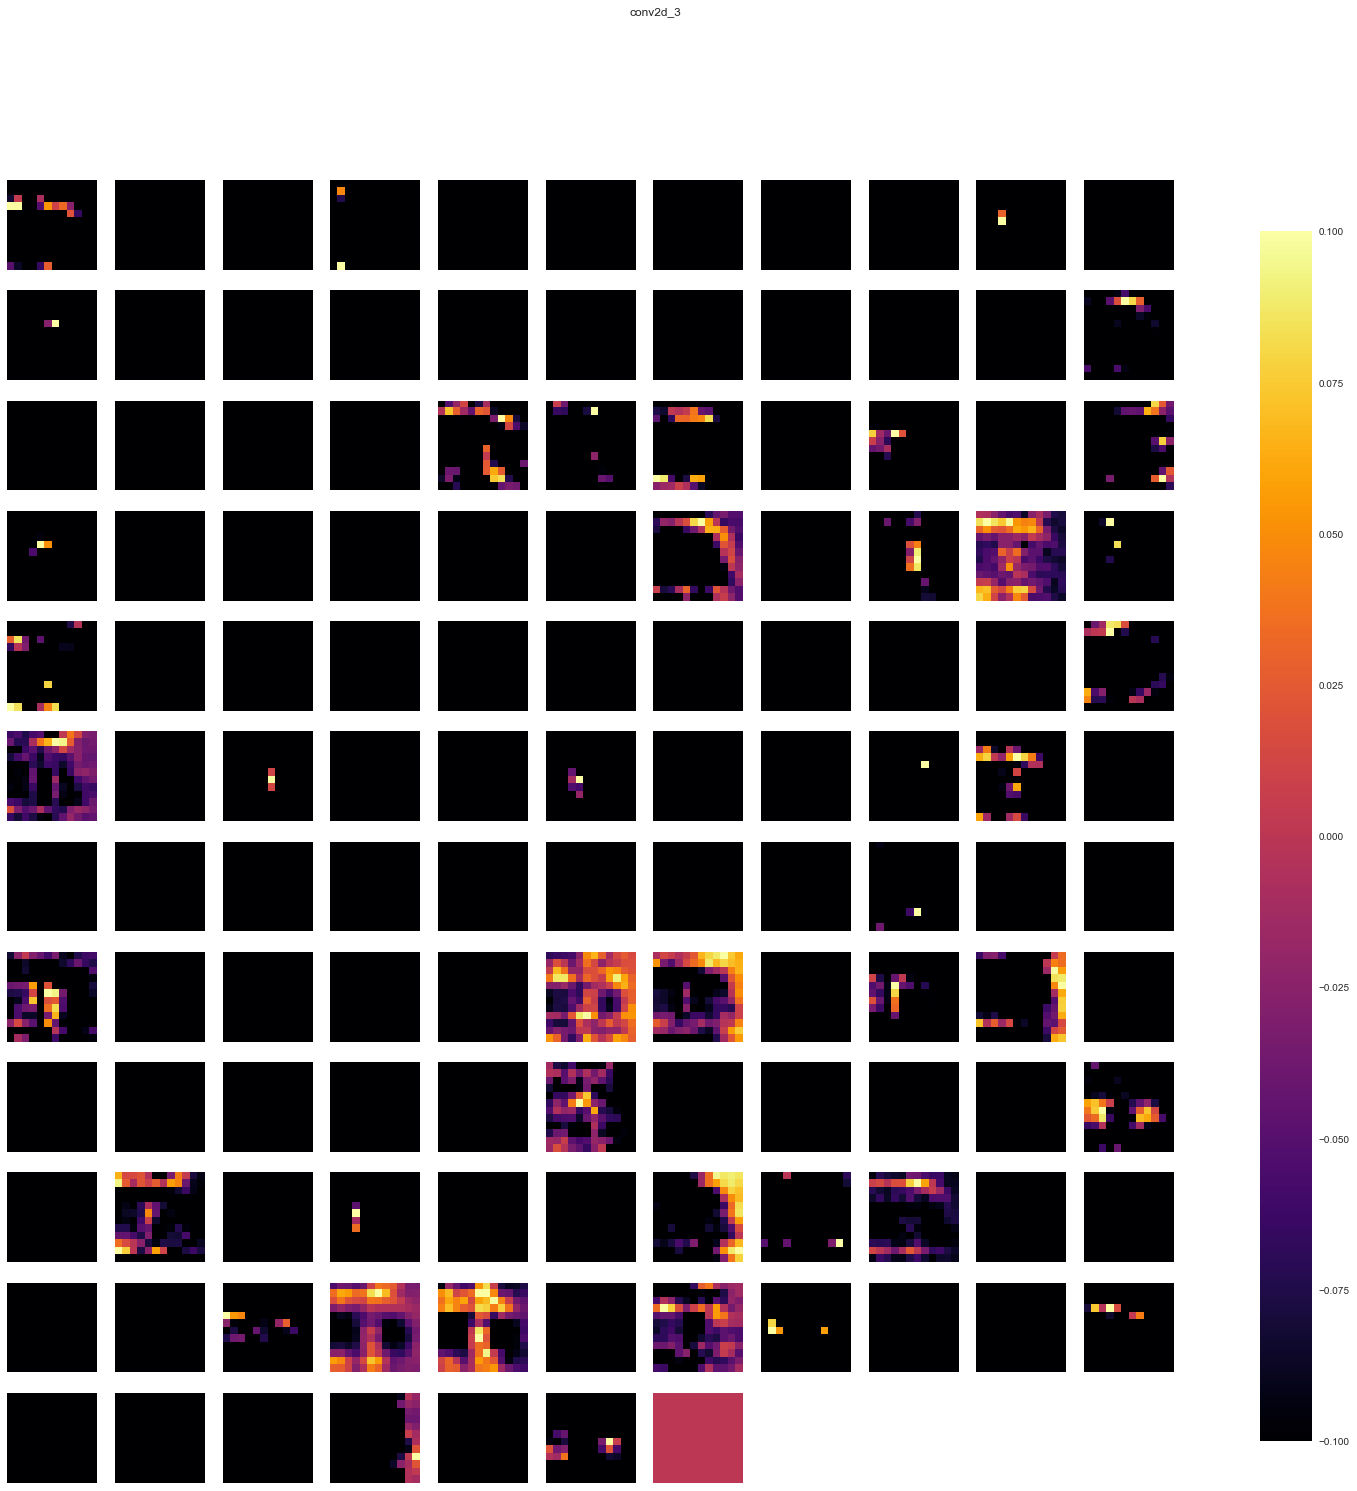

In [7]:
activations = get_activations(loaded_model,keract_damaged_img.reshape(1,128,128,3),
                              layer_names=['conv2d_input_1','conv2d','conv2d_1','conv2d_2','conv2d_3'])
display_activations(activations,cmap= 'inferno',save=False)

## Heatmap of gradients

We can generate heatmaps using the gradients of a convolution layer to get a better sense of what the model is seeing.


In [355]:
def get_heatmap(y):
    """Takes an input image and returns the gradient heatmap of that image"""
    preds = loaded_model.predict(y)
    class_idx = np.argmax(preds)
    class_output = loaded_model.output[:, class_idx]
    last_conv_layer = loaded_model.get_layer('conv2d_3')
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([loaded_model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([y])
    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap
    

In [356]:
def preprocess_img(x):
    """Scales and resizes image in order to make predictions from model"""
    y = x/255
    y= y.reshape(1,128,128,3)
    return y

In [349]:
#generate list of random index from our dataset
np.random.seed(9)
random_list = np.random.randint(0,len(train_df), 10)

In [350]:
# create a list of image paths from our random list
image_list_path = []
for index in random_list:
    temp_path = train_df.loc[index,'path']
    image_list_path.append(temp_path)
    
    
    
    

In [351]:
#generate predictions using our model on the randomly selected images
predictions = []
for i in image_list_path:
    img = cv2.imread(i)
    img = preprocess_img(img)
    pred = loaded_model.predict(img)
    predictions.append(pred)
predictions = np.array(predictions)

In [352]:
#get the true labels from our dataset
damage_list = train_df.loc[random_list,'damage'].reset_index(drop=True)

In [353]:
# Iterate over our images and get the heatmaps of each image in our list
original_image_list = []
heatmap_image_list = []
for i in image_list_path:
    img = cv2.imread(i)
    img_p = preprocess_img(img)
    heatmap = cv2.resize(get_heatmap(img_p), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    original_image_list.append(img)
    heatmap_image_list.append(superimposed_img)
    

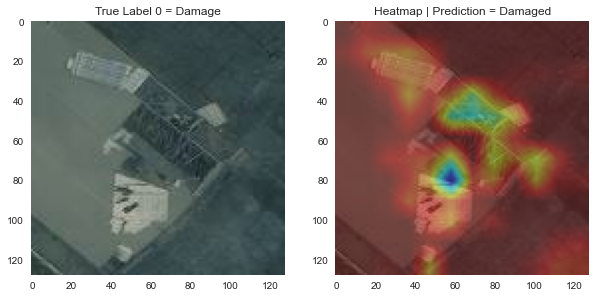

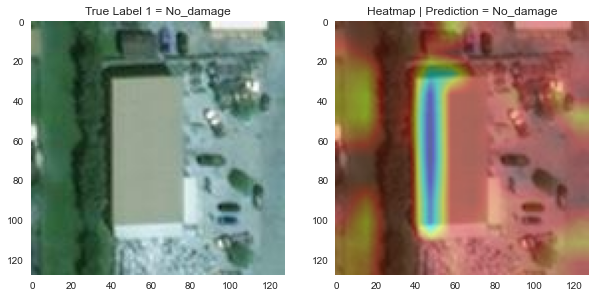

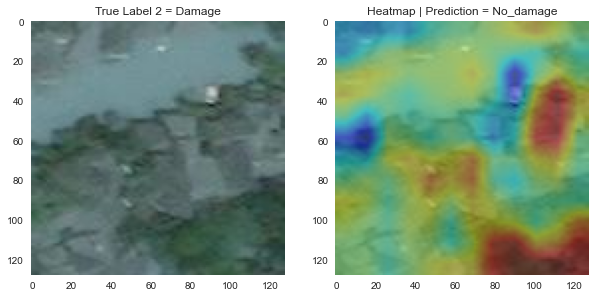

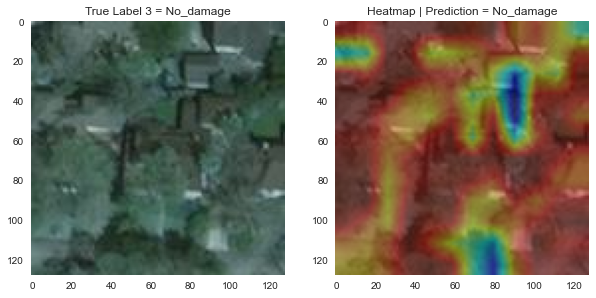

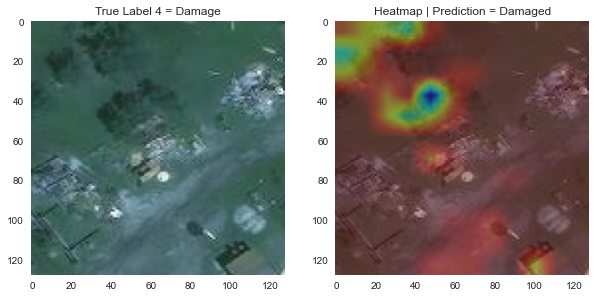

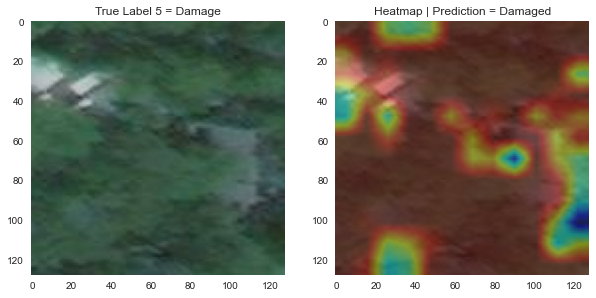

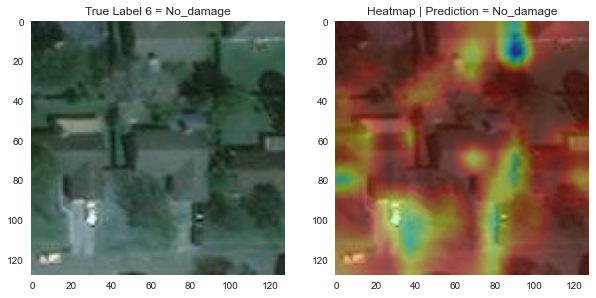

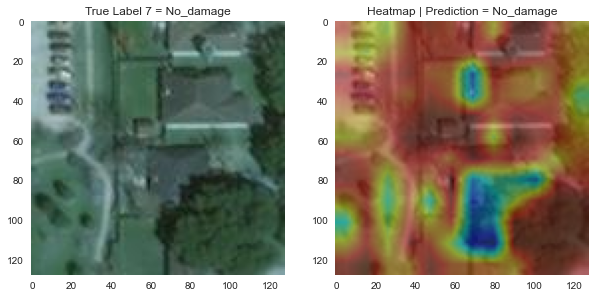

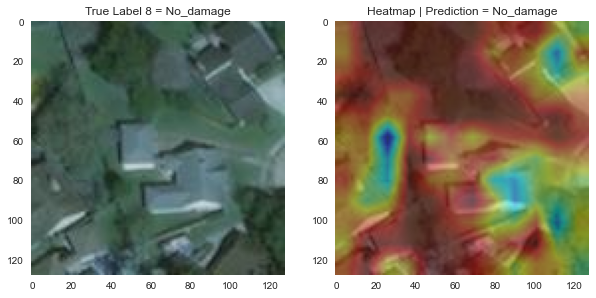

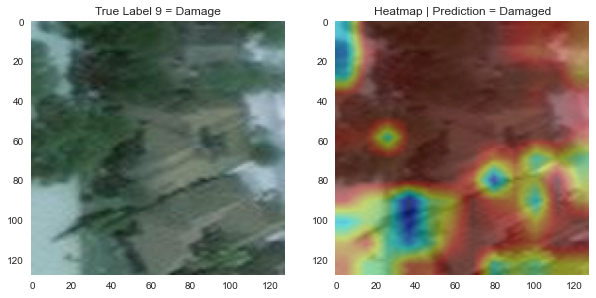

In [354]:
#Plot original vs. heatmap image
for i in range(0,len(heatmap_image_list)): 
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.imshow(original_image_list[i])
    title = 'True Label ' + str(i) + ' = ' + damage_list[i].capitalize()
    plt.title(title)
    plt.grid(False)
    plt.subplot(1,2,2)
    plt.imshow(heatmap_image_list[i])
    title = 'Heatmap | Prediction = ' + ('No_damage' if predictions[i] > 0.5 else 'Damaged')
    plt.title(title)
    plt.grid(False)
    plt.show()